In [62]:
from osgeo import gdal
import subprocess as sp
import os
from hkvfewspy.io import untangle
import glob
import pandas as pd

In [63]:
def cmd(command, parse_directly=False):
    
    if parse_directly==True:
        print(command)
        norm = sp.Popen(command,stdout=sp.PIPE, shell=True)
    else:
        print(sp.list2cmdline(command))
        norm = sp.Popen(sp.list2cmdline(command),stdout=sp.PIPE, shell=True)            
             
    out_cmd = norm.communicate()
    return out_cmd

In [80]:
def get_xy(gdalraster, X, Y):
    command = [gdallocationinfo,'-xml', '-geoloc', gdalraster, X, Y]
    norm = cmd(command)
    print(norm)
    xml = untangle.parse_raw(norm[0].decode('utf8'))
    
    return float(xml.Report.BandReport.Value.cdata)
    
rootOgrGdal = r'C:\Python35\Lib\site-packages\osgeo'
gdallocationinfo = os.path.join(rootOgrGdal, 'gdallocationinfo.exe')    

In [134]:
path_in = r'D:\FEWSProjecten\OmsWaddenzee\trunk\fews\Import\hkv\coefficienten\asciiData//*/*/grid163*.asc'
asc_files = glob.glob(path_in, recursive=True)

In [137]:
df = pd.DataFrame(columns=['coefficient', 'winddirection', 'value'])

X = '151197.5'
Y = '566321.5'

for idx, in_file in enumerate(asc_files):
    # get the right paths and filenames
    dir_name = os.path.dirname(in_file)
    split_path = dir_name.split(os.sep)
    wind_dir = split_path[-1]
    coef_AB = split_path[-2]
    
    df.at[str(idx)] = pd.np.nan
    df.at[str(idx),'coefficient'] = coef_AB
    df.at[str(idx),'winddirection'] = wind_dir 
    
    df.at[str(idx),'value'] = get_xy(in_file, X, Y)

C:\Python35\Lib\site-packages\osgeo\gdallocationinfo.exe -xml -geoloc D:\FEWSProjecten\OmsWaddenzee\trunk\fews\Import\hkv\coefficienten\asciiData\ruweData_A\WD_000_090\grid163_20180801000000.asc 151197.5 566321.5
(b'<Report pixel="222" line="98">\r\n  <BandReport band="1">\r\n    <Value>-0.000432046304922551</Value>\r\n  </BandReport>\r\n</Report>\r\n', None)
C:\Python35\Lib\site-packages\osgeo\gdallocationinfo.exe -xml -geoloc D:\FEWSProjecten\OmsWaddenzee\trunk\fews\Import\hkv\coefficienten\asciiData\ruweData_A\WD_090_180\grid163_20180801000000.asc 151197.5 566321.5
(b'<Report pixel="222" line="98">\r\n  <BandReport band="1">\r\n    <Value>0</Value>\r\n  </BandReport>\r\n</Report>\r\n', None)
C:\Python35\Lib\site-packages\osgeo\gdallocationinfo.exe -xml -geoloc D:\FEWSProjecten\OmsWaddenzee\trunk\fews\Import\hkv\coefficienten\asciiData\ruweData_A\WD_180_270\grid163_20180801000000.asc 151197.5 566321.5
(b'<Report pixel="222" line="98">\r\n  <BandReport band="1">\r\n    <Value>0</Value

In [123]:
path_wind = r'D:\FEWSProjecten\OmsWaddenzee\trunk\fews\Import\hkv\wind_forecast\wind_dir_vel_20180731.csv'
df_wind = pd.read_csv(path_wind)
df_wind.set_index('date', inplace=True)
# path_wind = r'D:\FEWSProjecten\OmsWaddenzee\trunk\fews\Import\hkv\wind_forecast\wind_dir_vel_20180801.csv'
# df_wind = pd.read_csv(path_wind)
# df_wind.set_index('date', inplace=True)

In [133]:
df

,coefficient,winddirection,value
0,ruweData_A,WD_000_090,-0.000432046
1,ruweData_A,WD_090_180,0
2,ruweData_A,WD_180_270,0
3,ruweData_A,WD_270_360,0.000163085
4,ruweData_B,WD_000_090,0.00366724
5,ruweData_B,WD_090_180,9.87171e-06
6,ruweData_B,WD_180_270,-0.000193042
7,ruweData_B,WD_270_360,-0.000957495


In [124]:
df_wind

,wind_direction,wind_velocity
date,,
2018-07-29,2,6.269306
2018-07-30,2,4.300198
2018-07-31,2,2.813051
2018-08-01,2,2.676971
2018-08-02,2,2.348977
2018-08-03,2,2.158635
2018-08-04,2,3.079565
2018-08-05,0,5.159536
2018-08-06,0,5.360423


In [141]:
def select_coef(df, wdir, coef):
    A = df['value'][(df['winddirection'] == wdir) & (df['coefficient'] == coef)].values[0]
    return A

df_sds = pd.DataFrame()
for idx, val in df_wind.iterrows():
    print(idx)
    print(val.wind_direction)
    if val.wind_direction == 0:
        A = select_coef(df, wdir='WD_000_090', coef='ruweData_A')
        B = select_coef(df, wdir='WD_000_090', coef='ruweData_B')
    elif val.wind_direction == 1:
        A = select_coef(df, wdir='WD_090_180', coef='ruweData_A')
        B = select_coef(df, wdir='WD_090_180', coef='ruweData_B')
    elif val.wind_direction == 2:
        A = select_coef(df, wdir='WD_180_270', coef='ruweData_A')
        B = select_coef(df, wdir='WD_180_270', coef='ruweData_B')      
    elif val.wind_direction == 3:
        A = select_coef(df, wdir='WD_270_360', coef='ruweData_A')
        B = select_coef(df, wdir='WD_270_360', coef='ruweData_B')              
    print(A, val.wind_velocity, B)
    df_sds.at[val.name,'sds'] = A * val.wind_velocity + B
    print(A * val.wind_velocity + B)
    print('\n')

2018-07-29
2.0
0.0 6.269306253503871 -0.000193041953025386
-0.000193041953025386


2018-07-30
2.0
0.0 4.300198343065049 -0.000193041953025386
-0.000193041953025386


2018-07-31
2.0
0.0 2.813050517329464 -0.000193041953025386
-0.000193041953025386


2018-08-01
2.0
0.0 2.6769711882979785 -0.000193041953025386
-0.000193041953025386


2018-08-02
2.0
0.0 2.348976877000597 -0.000193041953025386
-0.000193041953025386


2018-08-03
2.0
0.0 2.158634733270716 -0.000193041953025386
-0.000193041953025386


2018-08-04
2.0
0.0 3.0795646596837924 -0.000193041953025386
-0.000193041953025386


2018-08-05
0.0
-0.000432046304922551 5.159535838939526 0.00366724212653935
0.0014380837322100536


2018-08-06
0.0
-0.000432046304922551 5.360423278808594 0.00366724212653935
0.0013512910561092714


2018-08-07
0.0
-0.000432046304922551 5.080377762405961 0.00366724212653935
0.0014722836866811568


2018-08-08
2.0
0.0 5.874873069480613 -0.000193041953025386
-0.000193041953025386


2018-08-09
2.0
0.0 6.327374776204428 

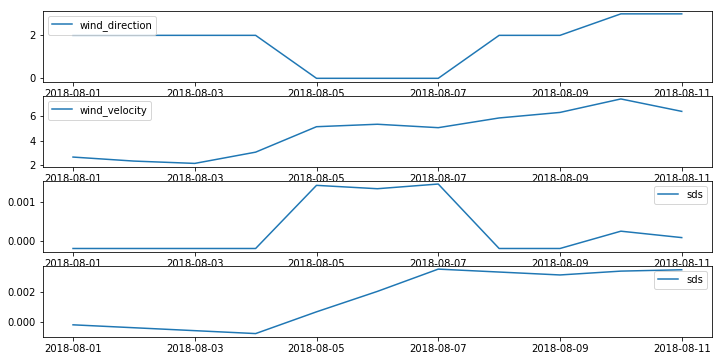

In [144]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12,6))

df_wind['2018-08-01':'2018-08-11']['wind_direction'].plot(ax=axes[0], legend=True)
df_wind['2018-08-01':'2018-08-11']['wind_velocity'].plot(ax=axes[1], legend=True)
df_sds['2018-08-01':'2018-08-11'].plot(ax=axes[2])
df_sds['2018-08-01':'2018-08-11'].cumsum().plot(ax=axes[3])

In [149]:
df_sds['2018-08-01':'2018-08-11'].cumsum()

,sds
2018-08-01,-0.000193
2018-08-02,-0.000386
2018-08-03,-0.000579
2018-08-04,-0.000772
2018-08-05,0.000666
2018-08-06,0.002017
2018-08-07,0.003489
2018-08-08,0.003296
2018-08-09,0.003103
2018-08-10,0.003358


In [130]:
df_wind['2018-08-01':'2018-08-11']

,wind_direction,wind_velocity
date,,
2018-08-01,2,2.676971
2018-08-02,2,2.348977
2018-08-03,2,2.158635
2018-08-04,2,3.079565
2018-08-05,0,5.159536
2018-08-06,0,5.360423
2018-08-07,0,5.080378
2018-08-08,2,5.874873
2018-08-09,2,6.327375


In [95]:
df

,coefficient,winddirection,value
0,ruweData_A,WD_000_090,-0.000432046
1,ruweData_A,WD_090_180,0
2,ruweData_A,WD_180_270,0
3,ruweData_A,WD_270_360,0.000163085
4,ruweData_B,WD_000_090,0.00366724
5,ruweData_B,WD_090_180,9.87171e-06
6,ruweData_B,WD_180_270,-0.000193042
7,ruweData_B,WD_270_360,-0.000957495


In [ ]:
A_NE_row_99_column_223 = -0.0004